In [1]:
import numpy as np
import json

In [2]:
dataset = "symmetric"

In [3]:
path = "/home/xianglin/projects/DVI_data/noisy/{}/cifar10/embedding.npy".format(dataset)
embeddings = np.load(path)

path = "/home/xianglin/projects/DVI_data/noisy/{}/cifar10/clean_label.json".format(dataset)
with open(path, "r") as f:
    clean_label = json.load(f)
path = "/home/xianglin/projects/DVI_data/noisy/{}/cifar10/noisy_label.json".format(dataset)
with open(path, "r") as f:
    noisy_label = json.load(f)

clean_label = np.array(clean_label)
noisy_label = np.array(noisy_label)

In [4]:
from noise_detector import NoiseTrajectoryDetector
ntd = NoiseTrajectoryDetector(embeddings, noisy_label)

In [5]:
cls_num=0
ntd.proj_cls(cls_num, repeat=2)

In [6]:
for cls_num in range(10):
    ntd.detect_noise_cls(cls_num)

silhouette_score	 0.5280765
calinski_harabasz_score	 3119.2536269097636
silhouette_score	 0.7523072
calinski_harabasz_score	 19269.645867449784
silhouette_score	 0.5720293
calinski_harabasz_score	 6525.881839270459
silhouette_score	 0.732662
calinski_harabasz_score	 9977.416844078276
silhouette_score	 0.70884115
calinski_harabasz_score	 3760.555664697312
silhouette_score	 0.78904325
calinski_harabasz_score	 13313.627689085088
silhouette_score	 0.6914137
calinski_harabasz_score	 6742.689340852467
silhouette_score	 0.64479154
calinski_harabasz_score	 4217.108184551923
silhouette_score	 0.79270613
calinski_harabasz_score	 18666.087709574917
silhouette_score	 0.7466922
calinski_harabasz_score	 16743.981232054764


In [5]:
ntd.proj_all()

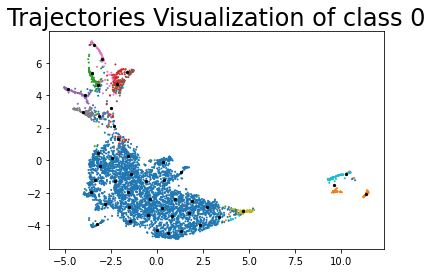

In [6]:
ntd.show_ground_truth(0,clean_label[noisy_label==0])

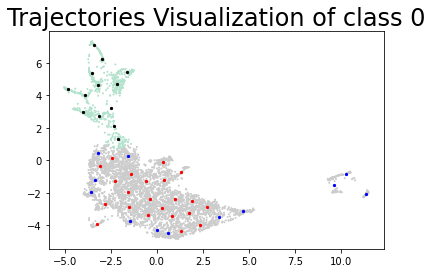

In [7]:
# ntd.update_belief(0, np.array([12, 10]), True)
ntd.show(0)

In [9]:
repr_centroid, noise_centroids, suspicious_centroids = ntd.select_cls_representative(cls_num)

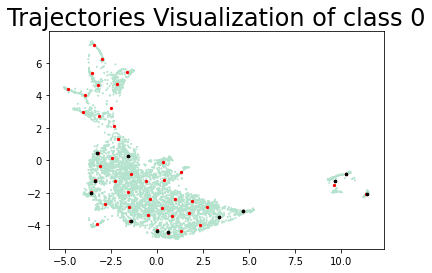

In [12]:
ntd.show_highlight(cls_num, suspicious_centroids)